## face similarity calculator

In [2]:
!pip install facenet-pytorch torch torchvision

# 2. Imports
from facenet_pytorch import InceptionResnetV1, MTCNN # InseptionResnetV1 embeds cropped face images into 512d vectors
import torch                                         # MTCNN detects and crops the faces in each image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import torch.nn.functional as F

In [14]:
# initialize face detector & embedding model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(device=device) # finds and crops faces
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device) # embeds faces into 512d vectors


# load image, detect and crop face, get embedding
def get_face_embedding(img_path):
    img = Image.open(img_path).convert('RGB')
    face = mtcnn(img)
    if face is None:
        raise ValueError(f"No face detected in {img_path}")
    with torch.no_grad():
        emb = resnet(face.unsqueeze(0).to(device))
        emb = F.normalize(emb, p=2, dim=1)      # <-- unit-normalize
    return emb.cpu().numpy().flatten()


# cosine similarity
def cosine_sim(a,b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))



In [16]:
def calculate_face_similarity(imgs):
  # imgs: img path array
  embs = [get_face_embedding(img) for img in imgs]

  # compute similarity matrix
  n = len(embs)
  # nxn numpy array
  sim_matrix = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      sim_matrix[i,j] = cosine_sim(embs[i], embs[j])


  labels = [img.split('/')[-1].split('.')[0] for img in imgs]

  # 2. Plot the heatmap
  plt.figure(figsize=(6, 6))
  plt.imshow(sim_matrix, interpolation='nearest', aspect='equal')
  plt.title("Face Embedding Cosine Similarity")
  plt.colorbar(fraction=0.046, pad=0.04)

  # 3. Configure axis ticks
  n = len(labels)
  plt.xticks(np.arange(n), labels, rotation=45, ha='right')
  plt.yticks(np.arange(n), labels)

  # 4. Annotate each cell with its numeric value
  for i in range(n):
      for j in range(n):
          plt.text(j, i, f"{sim_matrix[i, j]:.2f}",
                  ha='center', va='center', color='w' if sim_matrix[i,j]<0.5 else 'k')

  plt.tight_layout()
  plt.show()



In [19]:
img_paths = ['/content/f1.PNG', '/content/f2.PNG', '/content/f3.PNG', '/content/f4.PNG', '/content/f5.PNG']

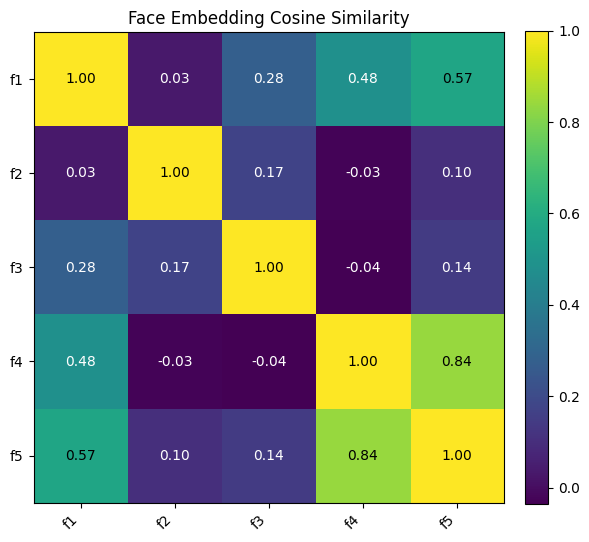

In [20]:
calculate_face_similarity(img_paths)